In [2]:
import numpy as np
import pandas as pd
import subprocess
from pathlib import Path
import json
from pprint import pprint
from tqdm import tqdm
import sys
from matplotlib import pyplot as plt
import copy

In [3]:
BUILD_PATH = '../dis-viz-backend/build'

binary_files = [ # must be absolute path
    '/home/insane/prapti/dis-viz/sample_inputs/bin/bubble-O3',
    '/home/insane/prapti/dis-viz/sample_inputs/bin/multisource-O3',
    '/home/insane/prapti/RAJAPerf/build/bin/raja-perf.exe'
]

args = [f"{BUILD_PATH}/DisViz", "-j", "--no-server"]
for bin in binary_files:
    args.append('-b')
    args.append(bin)

print(' '.join(args))
process = subprocess.Popen(args)
process.wait()

../dis-viz-backend/build/DisViz -j --no-server -b /home/insane/prapti/dis-viz/sample_inputs/bin/bubble-O3 -b /home/insane/prapti/dis-viz/sample_inputs/bin/multisource-O3 -b /home/insane/prapti/RAJAPerf/build/bin/raja-perf.exe
Disassembling [██████████████████████████████████████████████████] :00s<00m:00s] 
Disassembling [██████████████████████████████████████████████████] :00s<00m:00s] 
Disassembling [██████████████████████████████████████████████████] :18s<00m:00s] 


0

In [4]:
result = {}
for file in Path('json').glob('*'):
    with open(file, 'r') as f:
        result[file.stem] = json.load(f)

print([k for k in result.keys()])
sample = list(result.keys())[0]
print([k for k in result[sample].keys()])

['raja-perf.exe', 'bubble-O3', 'multisource-O3']
['functions', 'blocks_info']


In [8]:
bin_result = result['bubble-O3']

In [9]:
# Check if there is inlines
for func in bin_result['functions']:
    if 'inlines' in func:
        print(func['name'])
        pprint(func['inlines'])
        break

main
[{'callsite_file': '/home/insane/prapti/dis-viz/sample_inputs/bubble_sort.cpp',
  'callsite_line': 34,
  'name': 'std::basic_ostream<char, std::char_traits<char> >& std::operator<< '
          '<std::char_traits<char> >(std::basic_ostream<char, '
          'std::char_traits<char> >&, char const*)',
  'ranges': [{'end': 4337, 'start': 4313}]}]


In [6]:
for func in tqdm(bin_result['functions']):
    if 'loops' in func:
        for loop in func['loops']:
            if len(loop['backedges']) > 1:
                print(len(loop['backedges']))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5198/5198 [00:00<00:00, 3254028.69it/s]

2
2
2
2
2
2


Total number of blocks: 44096


Text(0, 0.5, 'Instructions')

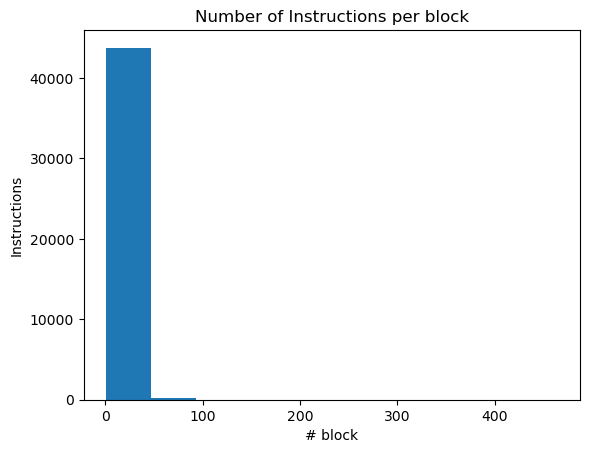

In [7]:
blocks = bin_result['blocks_info']['memory_order_blocks']

print(f"Total number of blocks: {len(blocks)}")
plt.hist(list(map(lambda block: block['n_instructions'], blocks)))
plt.title("Number of Instructions per block")
plt.xlabel("# block")
plt.ylabel("Instructions")

Total number of functions: 4885


Text(0, 0.5, 'Functions')

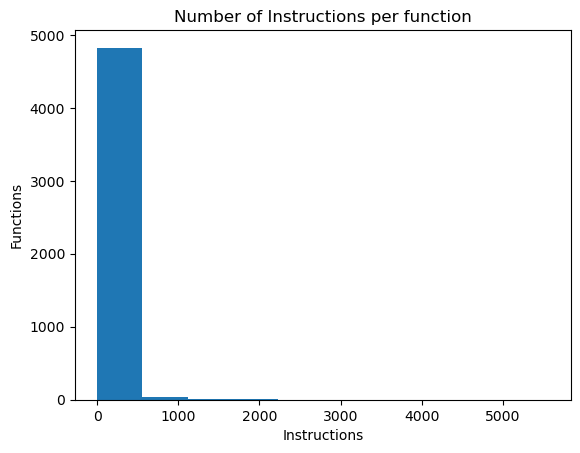

In [8]:
n_ins_per_function = {}

for block in blocks:
    if block['function_name'] not in n_ins_per_function:
        n_ins_per_function[block['function_name']] = 0
    n_ins_per_function[block['function_name']] += block['n_instructions']
    
print(f"Total number of functions: {len(n_ins_per_function)}")
plt.hist(n_ins_per_function.values())
plt.title("Number of Instructions per function")
plt.xlabel("Functions")
plt.ylabel("Instructions")

Total number of files: 256


Text(0, 0.5, 'Files')

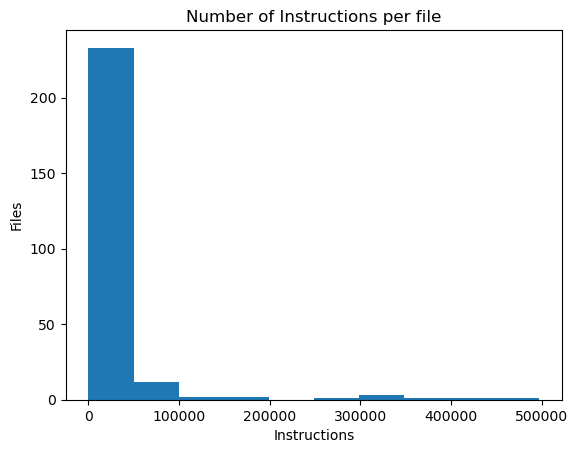

In [9]:
ins_count = {}
block_count = {}

for block in blocks:
    for instruction in block['instructions']:
        if 'correspondence' in instruction:
            for file_name in instruction['correspondence'].keys():
                if file_name not in ins_count:
                    ins_count[file_name] = 0
                    block_count[file_name] = 0
                ins_count[file_name] += block['n_instructions']
                block_count[file_name] += 1
        
        
print(f"Total number of files: {len(block_count)}")
plt.hist(ins_count.values())
plt.title("Number of Instructions per file")
plt.xlabel("Instructions")
plt.ylabel("Files")

# Loop lengths (Number of instructions per loop)

In [10]:
def flatten(xs):
    for x in xs:
        if isinstance(x, list) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

In [11]:
loops = list(flatten(filter(lambda loop: loop, map(lambda fn: copy.deepcopy(fn['loops']) if 'loops' in fn else [], bin_result['functions']))))

def flatten_inner_loops(loops):
    for loop in loops:
        if 'loops' in loop and loop['loops']:
            loops += flatten_inner_loops(loop['loops'])
    return loops
    
loops = flatten_inner_loops(loops)

print(f"Total inner+outer loops {len(loops)}")

loop_ids = list(range(len(loops)))

n_blocks = list(map(lambda loop: len(loop['blocks']), loops))

MAX_LOOPS = min(20000, len(loops))
n_instructions = []
for loop in tqdm(loops[:MAX_LOOPS]):
    cur_n_instructions = 0
    for block_number in loop['blocks']:
        cur_n_instructions += next(block for block in blocks if block['name'] == block_number)['n_instructions']
    n_instructions.append(cur_n_instructions)
    
df = pd.DataFrame(zip(n_blocks[:MAX_LOOPS], n_instructions), columns =["n_blocks", "n_instructions"], index=loop_ids[:MAX_LOOPS])
df

Total inner+outer loops 15564


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 15564/15564 [01:09<00:00, 222.41it/s]


,n_blocks,n_instructions
0,3,6
1,6,23
2,3,8
3,23,85
4,12,38
...,...,...
15559,2,29
15560,2,29
15561,2,29
15562,2,29


In [12]:
loop_blocks = list(map(lambda loop: sorted(loop['blocks']), loops))

def loop_has_consecutive_blocks(loop, blocks):
    start_block = min(filter(lambda block: block['name'] in loop, blocks), key=lambda block: block['start_address'])
    sorted_blocks = sorted(blocks, key=lambda block: block['start_address'])
    start_block_idx = next(idx for idx, block in enumerate(sorted_blocks) if block['name'] == start_block['name'])
    
    for i in range(1, len(loop)):
        if sorted_blocks[start_block_idx + i]['name'] not in loop:
            return False
    return True

loops_without_consecutive_blocks_idx = [idx for idx, loop_block in tqdm(enumerate(loop_blocks)) if not loop_has_consecutive_blocks(loop_block, blocks)]
print(f"Total loops that contain non-consecutive blocks : {len(loops_without_consecutive_blocks_idx)}/{len(loop_blocks)}")

15564it [03:13, 80.60it/s] 

Total loops that contain non-consecutive blocks : 160/15564


In [13]:
#pprint([function for function in functions if function.name == 'rajaperf::KernelBase::hasVariantTuningDefined'][1].loops)

In [18]:
non_consecutive_blocks_loop = []

consec_blocks_loop = []
nonconsec_blocks_loop = []

for i in loops_without_consecutive_blocks_idx:
    non_consecutive_blocks_loop.append(loop_blocks[i])

for non_cons_block_loop in tqdm(non_consecutive_blocks_loop):
    non_cons_blocks = []
    for block_name in non_cons_block_loop:
        for block in blocks:
            if block['name'] == block_name:
                non_cons_blocks.append(block)
                break
                
    nonconsec_blocks_loop.append(non_cons_blocks)
    non_cons_blocks.sort(key=lambda x: x['start_address'])
    
    first_block = non_cons_blocks[0]
    last_block = non_cons_blocks[-1]
    
    sorted_blocks = sorted(blocks, key=lambda block: block['start_address'])
    block_idx = next(idx for idx, block in enumerate(sorted_blocks) if block['name'] == first_block['name'])
    
    counter = 0
    current_consec_blocks = []
    for block in sorted_blocks[block_idx:]:
        counter += 1
        current_consec_blocks.append(block)
        if block['name'] == last_block['name']:
            break
    consec_blocks_loop.append(current_consec_blocks)

100%|███████████████████████████████████████████████████| 160/160 [00:34<00:00,  4.66it/s]


In [19]:
for idx in loops_without_consecutive_blocks_idx[:2]:
    pprint(len(loop_blocks[idx]))

6
6


In [20]:
non_consecutive_blocks_loop[:2]

[['rajaperf::KernelBase::hasVariantTuningDefined: B2799',
  'rajaperf::KernelBase::hasVariantTuningDefined: B2800',
  'rajaperf::KernelBase::hasVariantTuningDefined: B2801',
  'rajaperf::KernelBase::hasVariantTuningDefined: B2803',
  'rajaperf::KernelBase::hasVariantTuningDefined: B2804',
  'rajaperf::KernelBase::hasVariantTuningDefined: B2805'],
 ['rajaperf::KernelBase::getVariantTuningIndex: B2812',
  'rajaperf::KernelBase::getVariantTuningIndex: B2813',
  'rajaperf::KernelBase::getVariantTuningIndex: B2814',
  'rajaperf::KernelBase::getVariantTuningIndex: B2816',
  'rajaperf::KernelBase::getVariantTuningIndex: B2817',
  'rajaperf::KernelBase::getVariantTuningIndex: B2818']]

In [22]:
len_diff_loops = []
for cons_loop, noncons_loop in zip(consec_blocks_loop, nonconsec_blocks_loop):
    len_diff_loops.append(len(cons_loop) - len(noncons_loop))

df = pd.DataFrame(len_diff_loops, columns =["skipped_blocks"])
df_hist = df.skipped_blocks.value_counts().reset_index().rename(columns={'index': 'Skipped Blocks', 'skipped_blocks': 'Loop Counts'})
df_hist.sort_values(by=['Skipped Blocks'])

,Skipped Blocks,Loop Counts
0,2,66
3,3,14
1,4,25
2,5,15
7,6,3
5,7,5
4,8,6
26,9,1
6,10,4
8,11,2


Text(0, 0.5, '')

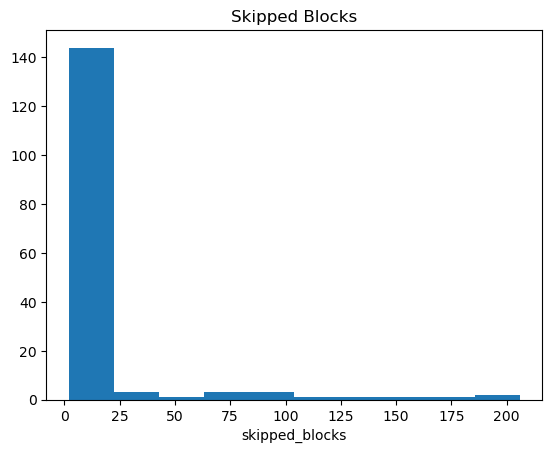

In [25]:
# px.histogram(df, x='skipped_blocks', title="Skipped Blocks", labels={'x':'skipped_blocks'}, nbins=100)

plt.hist(df['skipped_blocks'])
plt.title("Skipped Blocks")
plt.xlabel("skipped_blocks")
plt.ylabel("")

In [30]:
print("Some of the non-consecutive block loops are: ")
for idx in loops_without_consecutive_blocks_idx[:3]:
    pprint(loop_blocks[idx])

Some of the non-consecutive block loops are: 
['rajaperf::KernelBase::hasVariantTuningDefined: B2799',
 'rajaperf::KernelBase::hasVariantTuningDefined: B2800',
 'rajaperf::KernelBase::hasVariantTuningDefined: B2801',
 'rajaperf::KernelBase::hasVariantTuningDefined: B2803',
 'rajaperf::KernelBase::hasVariantTuningDefined: B2804',
 'rajaperf::KernelBase::hasVariantTuningDefined: B2805']
['rajaperf::KernelBase::getVariantTuningIndex: B2812',
 'rajaperf::KernelBase::getVariantTuningIndex: B2813',
 'rajaperf::KernelBase::getVariantTuningIndex: B2814',
 'rajaperf::KernelBase::getVariantTuningIndex: B2816',
 'rajaperf::KernelBase::getVariantTuningIndex: B2817',
 'rajaperf::KernelBase::getVariantTuningIndex: B2818']
['std::_Hashtable<std::__cxx11::basic_string<char, std::char_traits<char>, '
 'std::allocator<char> >, std::pair<std::__cxx11::basic_string<char, '
 'std::char_traits<char>, std::allocator<char> > const, unsigned long>, '
 'std::allocator<std::pair<std::__cxx11::basic_string<char, 